In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-from-text/tweet_emotions.csv
/kaggle/input/emotion-data/sample_submission.csv
/kaggle/input/emotion-data/train.csv
/kaggle/input/emotion-data/test.csv


In [3]:
df = pd.read_csv("../input/emotion-data/train.csv")
df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1,0
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,2018-En-01993,@BadHombreNPS @SecretaryPerry If this didn't m...,1,0,1,0,0,0,0,0,0,0,0,0
7720,2018-En-01784,Excited to watch #stateoforigin tonight! Come ...,0,0,0,0,1,0,1,0,0,0,0,0
7721,2018-En-04047,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...",1,0,1,0,0,0,0,0,1,0,0,0
7722,2018-En-03041,#ThingsIveLearned The wise #shepherd never tru...,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
import nltk
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

nltk.download('words')
from nltk.corpus import words
  
correct_words = words.words()


def spelling_fix(text):
    new_text = []
    incorrect_words = nltk.word_tokenize(text)
    for word in incorrect_words:
        temp = [(jaccard_distance(set(ngrams(word, 2)),
                                  set(ngrams(w, 2))),w)
                for w in correct_words if w[0]==word[0]]
        most_similar_list = sorted(temp, key = lambda val:val[0])
        
        if len(most_similar_list) == 0:
            new_text.append(word)
            continue
            
        if most_similar_list[0][0] >= 0.9:
            new_text.append(most_similar_list[0][1])
        else:
            new_text.append(word)
            
    return " ".join(new_text)

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def remove_emoji(text):
    regex_pattern = re.compile("["                               
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1E6-\U0001F1FF"  # flags                              
                               "]+", flags=re.UNICODE)

    return regex_pattern.sub(r'', text)


def remove_email(text):
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', '', text)


def remove_repeated_char(text):
    return re.sub(r'(.)\1\1{1,}', r'\1\1', text)


def remove_account_tag(text):
    return re.sub(r'@[\w]+', '', text)


def remove_hashtag(text):
    return re.sub(r'#[\w]+', '', text)


def remove_links(text):
    return re.sub(r'http[^\s]+', '', text)


def remove_spaces(text):
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    return text


def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return " ".join([w for w in word_tokens if not w in stop_words])


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", '', text)


def lemmatize(text):
    new_text = []
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        tmp_w = wordnet_lemmatizer.lemmatize(w)
        if tmp_w is None:
            new_text.append(w)
        else:
            new_text.append(tmp_w)
    return " ".join(new_text)


def preprocess_text_sample(text):
    text = remove_emoji(text)
    text = remove_email(text)
    text = remove_repeated_char(text)
    text = remove_account_tag(text)
    text = remove_hashtag(text)
    text = remove_links(text)
    text = remove_stop_words(text)
    text = remove_spaces(text)
    text = remove_less_2_characters(text)
    text = text.strip()
    text = text.lower()
    #text = spelling_fix(text)
    text = lemmatize(text)
    return text


def preprocess_text_cols(df, col):
    df[col] = df[col].apply(lambda x: preprocess_text_sample(x))
    return df


def preprocess_df(df, col="content"):
    df = preprocess_text_cols(df, col)
    df.dropna(inplace=True)
    return df

In [6]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)

In [7]:
num_classes = 12

In [20]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('punkt')
nltk.download('wordnet')

oov_tok = "<oov_tok>"

def count_vectorizer(corpus):
    vectorizer = CountVectorizer(analyzer='word')
    corpus_words = vectorizer.fit_transform(corpus)
    return len(vectorizer.vocabulary_)


def get_tokenizer_obj(text_list, num_words):
    tokenizer = Tokenizer(lower=True, split=" ", num_words=num_words, oov_token=oov_tok)
    tokenizer.fit_on_texts(text_list)
    return tokenizer, len(tokenizer.word_index)


def tokenize_texts_to_sequences(tokenizer, text_list):
     return tokenizer.texts_to_sequences(text_list)

    
def padding_sequences(x_arr, max_len):
    x_arr = pad_sequences(x_arr, maxlen=max_len, value=0, padding='post')
    return x_arr 


def get_num_words(df, col):
    return count_vectorizer(df[col])


def get_max_statment_len(df, col):
    return max([len(text.split()) for text in df[col]])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.classes_],
                  columns = [i for i in label_encoder.classes_])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.classes_))

In [9]:
SEQ_LEN = 35

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [11]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [15]:
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import emoji
import re
import string

In [16]:
df['Tweet'] = df['Tweet'].apply(text_preprocessing_pipeline)

In [21]:
X = tokenize_texts_to_sequences(tokenizer, df["Tweet"].values)
X = padding_sequences(X, 35)

NameError: name 'tokenizer' is not defined

In [18]:
y = df.drop(["Tweet", "ID"], axis=1).values

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

NameError: name 'train_test_split' is not defined

In [36]:
!pip install livelossplot

In [37]:
import tensorflow as tf
import keras.backend as K


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [38]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Input, Dropout, Conv1D, Reshape, Permute, Lambda
from keras.layers import RepeatVector, Flatten, multiply, Dropout
from keras.models import Model
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from os.path import join
import time


def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return modell

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, TIME_STEPS):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) 
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

def build_model(MAX_NB_WORDS,
                MAX_TEXT_LEN,
                nb_classes,
                learning_rate=2e-5,
                epsilon=1e-08):
    EMBEDDING_DIM = 100
    inputs = Input(name='inputs',shape=[MAX_TEXT_LEN])
    layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_TEXT_LEN)(inputs)
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out, MAX_TEXT_LEN)
    attention_mul = Flatten()(attention_mul)
    output = Dense(nb_classes, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate,epsilon=epsilon),
                  loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])
    print(model.summary())
    return model


def train_model(model, X_train, y_train, X_val, y_val,
                #class_weights,
                weights_dir,
                epochs=20,
                mini_batch_size=32,
                ):
    model_weights_file_path = join(weights_dir, "custom_model_weights.h5")
    checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=50)
    plotlosses = PlotLossesKeras()
    call_backs = [checkpoint, early_stopping, plotlosses]
    start_time = time.time()

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=mini_batch_size,
                        callbacks=call_backs,
                        #class_weight=class_weights,
                        verbose=1)

    duration = time.time() - start_time
    print("Model take {} S to train ".format(duration))
    return model, history


def predict(model, X_test):
    return model.predict(X_test)

In [54]:
max_text_length = X_train.shape[1]
model = build_model(vocab_size,                    
                    max_text_length,
                    12,
                    learning_rate=0.001)


2022-10-13 14:29:47.987342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:29:47.999094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:29:47.999791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:29:48.001835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      4555900     inputs[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 35, 64)       42240       embedding[0][0]                  
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 35)       0           lstm[0][0]                       
______________________________________________________________________________________________

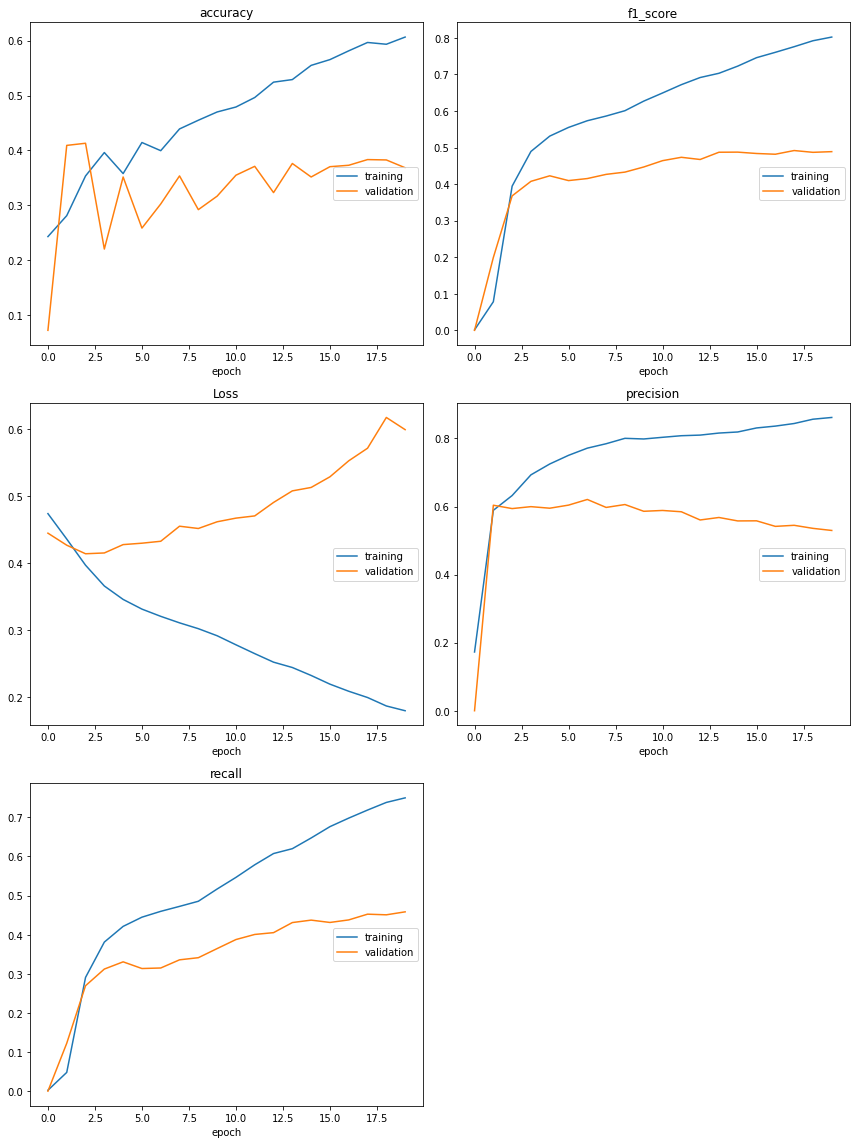

accuracy
	training         	 (min:    0.243, max:    0.607, cur:    0.607)
	validation       	 (min:    0.072, max:    0.413, cur:    0.368)
f1_score
	training         	 (min:    0.001, max:    0.802, cur:    0.802)
	validation       	 (min:    0.000, max:    0.492, cur:    0.489)
Loss
	training         	 (min:    0.179, max:    0.473, cur:    0.179)
	validation       	 (min:    0.414, max:    0.617, cur:    0.599)
precision
	training         	 (min:    0.173, max:    0.862, cur:    0.862)
	validation       	 (min:    0.000, max:    0.621, cur:    0.530)
recall
	training         	 (min:    0.002, max:    0.750, cur:    0.750)
	validation       	 (min:    0.000, max:    0.458, cur:    0.458)
Model take 84.0737156867981 S to train 


(<keras.engine.functional.Functional at 0x7fc01205f810>,
 <keras.callbacks.History at 0x7fc012f65590>)

In [55]:
weights_path = ""
train_model(model, X_train, y_train, 
            X_val, y_val,
            #class_weights,
            weights_path)

In [56]:
model.load_weights("./custom_model_weights.h5")

In [57]:
y_hat = model.predict(X_val)

In [92]:
ROC_plot(y_val, y_hat, label_encoder, num_classes)

IndexError: index 12 is out of bounds for axis 1 with size 12

In [93]:
y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_val, axis=1)
print_score(y_pred, y_real, label_encoder)

Accuracy:  0.42588996763754045
Precision::  0.42588996763754045
Recall::  0.42588996763754045
F1_Score::  0.42588996763754045

Macro precision_recall_fscore_support (macro) average
(0.18557093514523687, 0.19792813951711247, 0.17643233270273104, None)

Macro precision_recall_fscore_support (micro) average
(0.42588996763754045, 0.42588996763754045, 0.42588996763754045, None)

Macro precision_recall_fscore_support (weighted) average
(0.4359508493881891, 0.42588996763754045, 0.42342959310313116, None)

Confusion Matrix


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Shape of passed values is (11, 11), indices imply (13, 13)

In [22]:
sentences = df["Tweet"]
labels = y

In [23]:
# labels

In [24]:
# label_encoder = get_label_encoder_obj(labels)
# labels = get_y_label_encoder(label_encoder, labels)

In [25]:
num_classes=12

In [26]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
sent= sentences[0]

tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =35,pad_to_max_length = True,
return_attention_mask = True)

tokenized_sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': [101, 4737, 2003, 1037, 2091, 7909, 2006, 1037, 3291, 2017, 2089, 2196, 2031, 11830, 11527, 14354, 4105, 4737, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [28]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] worry is a down payment on a problem you may never have joyce meyer motivation leadership worry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [29]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [30]:
import pickle

pickle_inp_path='bert_inp.pkl'
pickle_mask_path='bert_mask.pkl'
pickle_label_path='bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)


Pickle files saved as  bert_inp.pkl bert_mask.pkl bert_label.pkl


In [31]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))


Loading the saved pickle files..
Input shape (7724, 64) Attention mask shape (7724, 64) Input label shape (7724, 12)


In [32]:
from sklearn.model_selection import train_test_split

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (6179, 64) Val input shape (1545, 64)
Train label shape (6179, 12) Val label shape (1545, 12)
Train attention mask shape (6179, 64) Val attention mask shape (1545, 64)


In [33]:
# class_weights = get_class_weights(train_label)
# class_weights

In [39]:
import tensorflow as tf
import keras

log_dir='tb_bert'
weights_dir = ""
model_save_path=os.path.join(weights_dir, 'bert_model.h5')

callbacks = [ModelCheckpoint(filepath=model_save_path,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True), 
             EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5),
             PlotLossesKeras(),
             keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  9228      
Total params: 109,491,468
Trainable params: 109,491,468
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [41]:
start_time = time.time()

history=bert_model.fit([train_inp,train_mask],train_label,
                       batch_size=32,epochs=20,
                       validation_data=([val_inp,val_mask],val_label),)

duration = time.time() - start_time
print("Model take {} S to train ".format(duration))

Epoch 1/20


TypeError: 'NoneType' object is not callable

In [ ]:
bert_model.load_weights("./bert_model.h5")

In [ ]:
y_hat = bert_model.predict([val_inp,val_mask])[0]
y_hat = np.argmax(y_hat, axis=1).flatten()
y_hat = y_hat.flatten()

In [ ]:
y_hat = one_hot_encode(y_hat, num_classes)
y_true = one_hot_encode(val_label, num_classes)

In [ ]:
y_hat.shape, y_true.shape

In [ ]:
ROC_plot(y_true, y_hat, label_encoder, num_classes)

In [ ]:
y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_true, axis=1)
print_score(y_pred, y_real, label_encoder)

## TAKES MUCH TIME FOR RE TRAIN

In [ ]:
train, val = train_test_split(df, test_size=0.1, random_state=2, stratify=df["sentiment"])

label_encoder = get_label_encoder_obj(train["sentiment"])
train["sentiment"] = get_y_label_encoder(label_encoder, train["sentiment"])
val["sentiment"] = get_y_label_encoder(label_encoder, val["sentiment"])

X_train = train["content"].values
y_train = train["sentiment"].values
X_val = val["content"].values
y_val = val["sentiment"].values


In [ ]:
!pip install sentencepiece
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 

In [ ]:
albert_url='https://tfhub.dev/tensorflow/albert_en_base/2'
encoder = hub.KerasLayer(albert_url)

preprocessor_url="https://tfhub.dev/tensorflow/albert_en_preprocess/3"
preprocessor = hub.KerasLayer(preprocessor_url)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)

In [ ]:
encoder_inputs

In [ ]:
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]     
sequence_output = outputs["sequence_output"]
pooled_output

In [ ]:
embedding_model = tf.keras.Model(text_input, pooled_output)

In [ ]:
albert_model = tf.keras.Sequential()
albert_model.add(embedding_model)

albert_model.add(tf.keras.layers.Dense(30, activation='relu'))
albert_model.add(tf.keras.layers.BatchNormalization())

albert_model.add(tf.keras.layers.Dense(num_classes))
albert_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
albert_model.summary()

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
weights_dir = ""
model_save_path=os.path.join(weights_dir, 'albert_model.h5')

callbacks = [ModelCheckpoint(filepath=model_save_path,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True), 
             EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5),
             PlotLossesKeras()]

In [ ]:
start_time = time.time()

history = albert_model.fit(X_train, y_train,
                            epochs=20,
                            batch_size=64,
                            validation_data=(X_val, y_val),
                            verbose=1)

duration = time.time() - start_time
print("Model take {} S to train ".format(duration))

In [ ]:
albert_model.save_weights("./albert_model.h5")

In [ ]:
albert_model.load_weights("./albert_model.h5")
y_hat = albert_model.predict(X_val)
y_hat = np.argmax(y_hat, axis=1).flatten()
y_hat = y_hat.flatten()

y_hat = one_hot_encode(y_hat, num_classes)
y_true = one_hot_encode(y_val, num_classes)

ROC_plot(y_true, y_hat, label_encoder, num_classes)

y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_true, axis=1)
print_score(y_pred, y_real, label_encoder)

In [ ]:
albert_url='https://tfhub.dev/tensorflow/albert_en_base/2'
encoder = hub.KerasLayer(albert_url,trainable=True)

preprocessor_url="https://tfhub.dev/tensorflow/albert_en_preprocess/3"
preprocessor = hub.KerasLayer(preprocessor_url)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]     
sequence_output = outputs["sequence_output"]

In [ ]:
embedding_model = tf.keras.Model(text_input, pooled_output)
albert2_model = tf.keras.Sequential()
albert2_model.add(embedding_model)
albert2_model.add(tf.keras.layers.Dense(128, activation='relu'))
albert2_model.add(tf.keras.layers.BatchNormalization())
albert2_model.add(tf.keras.layers.Dense(30, activation='relu'))
albert2_model.add(tf.keras.layers.BatchNormalization())
albert2_model.add(tf.keras.layers.Dense(8, activation='relu'))
albert2_model.add(tf.keras.layers.BatchNormalization())
albert2_model.add(tf.keras.layers.Dense(num_classes))
albert2_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])


In [ ]:
albert2_model.summary()

In [ ]:
weights_dir = ""
model_save_path=os.path.join(weights_dir, 'albert2_model.h5')

callbacks = [ModelCheckpoint(filepath=model_save_path,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True), 
             EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5),
             PlotLossesKeras()]

In [ ]:
start_time = time.time()

history = albert2_model.fit(X_train, y_train,
                            epochs=20,
                            batch_size=64,
                            validation_data=(X_val, y_val),
                            verbose=1)

duration = time.time() - start_time
print("Model take {} S to train ".format(duration))

In [ ]:
albert2_model.save_weights("./albert2_model.h5")

In [ ]:
albert2_model.load_weights("./albert2_model.h5")
y_hat = albert2_model.predict(X_val)
y_hat = np.argmax(y_hat, axis=1).flatten()
y_hat = y_hat.flatten()

y_hat = one_hot_encode(y_hat, num_classes)
y_true = one_hot_encode(y_val, num_classes)

ROC_plot(y_true, y_hat, label_encoder, num_classes)

y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_true, axis=1)
print_score(y_pred, y_real, label_encoder)